In [10]:
import sys
sys.path.append('..')
from JensenTools import *
import PyCrystalField as cef
import numpy as np
import matplotlib.pyplot as plt

In [11]:
# kwargs
#####################################################################################################################################################################
comp = 'Li8PrO6'
ion = 'Ce3+'
who = 'PPMS'
LS_on = True
Kmeans = True
LSValue = 100
numlevels = 4
# The L,S values are as follows for the Pr4+ ion
L = 3
S = 0.5
massErr = .00005
molweight = 380.15
#####################################################################################################################################################################

In [12]:
# Make LS_CFLevels object with best fit parameters
#####################################################################################################################################################################
B20  =  0.4858075931009187
B40  =  -0.6568663783690575
B44  =  -3.1415463304732714
B60  =  -0.02328250024945387
B64  =  0.504906552605772
LS  =  100.00007580463522

saveDir = getSaveDir('m',comp = comp) #General Directory for the project
MTDir = getSaveDir('m',comp = comp, dataType = 'MT') #MvsT data

stev = { 'B20' :B20, 'B40': B40, 'B44' : B44, 'B60': B60, 'B64' : B64 }

#Create the CFLevels object and diagonalize it
if LS_on:
	Pr = cef.LS_CFLevels.Bdict(Bdict = stev, L = L, S = S, SpinOrbitCoupling=LS)
	Pr.diagonalize()
else:
	Pr = cef.CFLevels.Bdict(Bdict = stev, ion = 'Ce3+')
	Pr.diagonalize()
#####################################################################################################################################################################

In [13]:
# Loading data for M vs T 
#####################################################################################################################################################################
runs = []
for i in os.listdir(MTDir):
    if i.endswith('.DAT') or i.endswith('.dat'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)
MTdata = {}
for i in runs:
    M,H,T,MErr,samplemass,measType = getData(i,MTDir, who = who, dataType = 'MT')
    MTdata[measType] = [M,H,T,MErr,samplemass]

#Either 'ZFC' or 'FC'
M,H,T,MErr,mass = MTdata['FC']
#####################################################################################################################################################################

In [14]:
# Use PCF to calculate Susceptibility (uB/T)
# Also do unit conversions
#####################################################################################################################################################################
fieldT = 0.1 #To match Arun's measurements
deltaField = .00001
if LS_on:
	XCalcBohr = Pr.susceptibility(Temps = T, Field = fieldT, deltaField = deltaField)
else:
	XCalcBohr = Pr.susceptibility(Temps = T, Field = fieldT, deltaField = deltaField, ion = ion)

## Normalize measured data per spin
M2 = normalize(M,mass,molweight, 'spin')
X2 = M2/H
Xi2 = 1/X2

## Normalize calculated susceptibility per mol. /10000 to get uB/Oe/mol
## Calculate inverse
# XCalcBohr = np.array(normalizeMol(XCalcBohr, mass, molweight))/10000
XCalcBohr = np.array(XCalcBohr)/10000
XiCalcBohr = 1/np.array(XCalcBohr)
## Convert to emu and calulcate inverse
XCalcEmu = bohrToEmu2(XCalcBohr)
XiCalcEmu = 1/np.array(XCalcEmu)

## Get measured data normalized susceptibility to Emu/Oe/Mol with error prop
XEmu,XErrEmu,XiEmu,XiErrEmu = normSusc(M,H,MErr,molweight,samplemass,massErr)
## Converting measured data to uB/Oe/Mol
XBohr = emuToBohr2(XEmu)
XiBohr = 1/np.array(XBohr)
#####################################################################################################################################################################

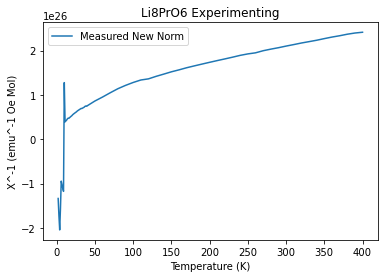

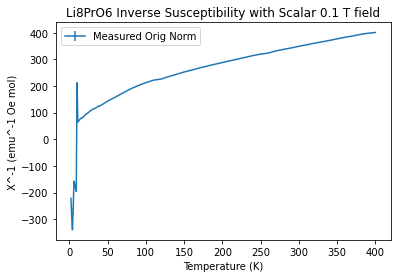

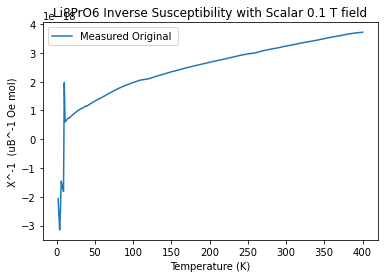

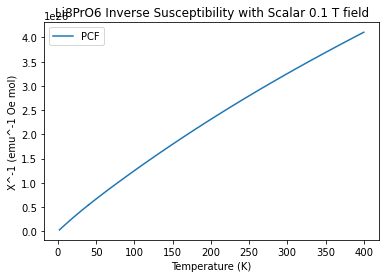

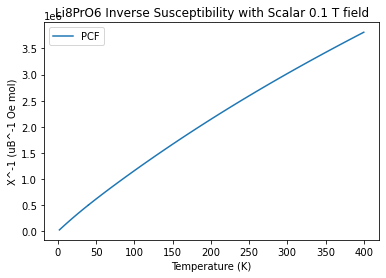

In [15]:
# Plot inverse susceptibility for:
# Calculated and measured: in (uB^-1 Oe Mol) and (emu^-1 Oe Mol)
#####################################################################################################################################################################
plt.figure()
plt.plot(T,Xi2, label = 'Measured New Norm')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1 (emu^-1 Oe Mol)')
# plt.ylabel('X^-1 (emu^-1 Oe)')
plt.title('{} Experimenting'.format(comp,fieldT))
plt.legend()


plt.figure()
plt.errorbar(T,XiEmu, yerr = XiErrEmu, label = 'Measured Orig Norm')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1 (emu^-1 Oe mol)')
# plt.ylabel('X^-1 (emu^-1 Oe)')
plt.title('{} Inverse Susceptibility with Scalar {} T field'.format(comp,fieldT))
plt.legend()

plt.figure()
plt.plot(T,XiBohr, label = 'Measured Original ')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1  (uB^-1 Oe mol)')
# plt.ylabel('X^-1 (uB^-1 Oe)')
plt.title('{} Inverse Susceptibility with Scalar {} T field'.format(comp,fieldT))
plt.legend()



plt.figure()
plt.plot(T,-1*XiCalcEmu, label = 'PCF')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1 (emu^-1 Oe mol)')
# plt.ylabel('X^-1  (emu^-1 Oe)')
plt.title('{} Inverse Susceptibility with Scalar {} T field'.format(comp,fieldT))
plt.legend()



plt.figure()
plt.plot(T,-1*XiCalcBohr, label = 'PCF')
plt.xlabel('Temperature (K)')
plt.ylabel('X^-1 (uB^-1 Oe mol)')
# plt.ylabel('X^-1 (uB^-1 Oe)')
plt.title('{} Inverse Susceptibility with Scalar {} T field'.format(comp,fieldT))
plt.legend()
plt.show()
#####################################################################################################################################################################